In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('cab_dataset.csv')


In [3]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [4]:
df.shape

(16067, 7)

In [5]:
df.dtypes

fare_amount           object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

In [6]:
df.isnull().sum()

fare_amount          24
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count      55
dtype: int64

In [7]:
df['fare_amount']=pd.to_numeric(df['fare_amount'],errors='coerce')
df.dropna(subset=['fare_amount'],inplace=True)


In [8]:
df=df[
(df['pickup_latitude'] != 0) & (df['pickup_longitude'] != 0) & 
(df['dropoff_latitude'] != 0) & (df['dropoff_longitude'] != 0) &
(df['fare_amount'] > 0) & (df['fare_amount'] < 200) &
(df['passenger_count'] >= 1) & (df['passenger_count'] <= 6)
]

In [9]:
df.shape

(15582, 7)

In [10]:
df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [11]:
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'],errors='coerce')
df.dropna(subset=['pickup_datetime'],inplace=True)

In [12]:
df['hour']=df['pickup_datetime'].dt.hour
df['day']=df['pickup_datetime'].dt.day
df['month']=df['pickup_datetime'].dt.month
df['weekday']=df['pickup_datetime'].dt.weekday
df['is_weekend']=df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

In [13]:
df['pickup_datetime']

0       2009-06-15 17:26:21+00:00
1       2010-01-05 16:52:16+00:00
2       2011-08-18 00:35:00+00:00
3       2012-04-21 04:30:42+00:00
4       2010-03-09 07:51:00+00:00
                   ...           
16061   2009-05-20 18:56:42+00:00
16062   2014-12-12 07:41:00+00:00
16063   2009-07-13 07:58:00+00:00
16064   2009-11-11 11:19:07+00:00
16065   2010-05-11 23:53:00+00:00
Name: pickup_datetime, Length: 15581, dtype: datetime64[ns, UTC]

In [14]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371 
    lat1,lon1,lat2,lon2=map(np.radians,[lat1,lon1,lat2,lon2])
    dlat=lat2-lat1
    dlon=lon2-lon1

    a=np.sin(dlat/2)**2+np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c=2*np.arcsin(np.sqrt(a))
    return R*c

In [15]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [16]:
from geopy.distance import geodesic

In [17]:
def dis_dur(row):
    try:
        pickup=(row['pickup_latitude'],row['pickup_longitude'])
        dropoff=(row['dropoff_latitude'],row['dropoff_longitude'])
        distance=geodesic(pickup,dropoff).kilometers
        duration=(distance/30)*60  
        return pd.Series([distance,duration])
    except:
        return pd.Series([np.nan,np.nan])


In [18]:
df[['Distance(km)','Duration(min)']]=df.apply(dis_dur,axis=1)


c:\Users\KIIT\anaconda3\Lib\site-packages\geopy\point.py:472: UserWarning: Latitude normalization has been prohibited in the newer versions of geopy, because the normalized value happened to be on a different pole, which is probably not what was meant. If you pass coordinates as positional args, please make sure that the order is (latitude, longitude) or (y, x) in Cartesian terms.
  return cls(*args)


In [19]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,is_weekend,Distance(km),Duration(min)
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1.0,17,15,6,0,0,1.029601,2.059201
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1.0,16,5,1,1,0,8.443441,16.886883
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2.0,0,18,8,3,0,1.389132,2.778264
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1.0,4,21,4,5,1,2.795790,5.591579
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1.0,7,9,3,1,0,1.998338,3.996676


In [20]:
df['Distance(km)'].isnull().sum()

1

In [21]:
m=df['Distance(km)'].isna()
df.loc[m,'Distance(km)']=haversine(
    df.loc[m,'pickup_latitude'],df.loc[m,'pickup_longitude'],
    df.loc[m,'dropoff_latitude'],df.loc[m,'dropoff_longitude']
)
df['Duration(min)'].fillna(df['Duration(min)'].median(),inplace=True)

C:\Users\KIIT\AppData\Local\Temp\ipykernel_15064\1511656381.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Duration(min)'].fillna(df['Duration(min)'].median(),inplace=True)


In [22]:
df['Distance(km)'].isnull().sum()

0

In [23]:
for col in ['Distance(km)','Duration(min)','fare_amount']:
    Q1=df[col].quantile(0.25)
    Q3=df[col].quantile(0.75)
    IQR=Q3-Q1
    df=df[(df[col]>=Q1-1.5*IQR)&(df[col]<=Q3+1.5*IQR)]

In [24]:
df.shape

(13236, 14)

In [25]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,is_weekend,Distance(km),Duration(min)
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1.0,17,15,6,0,0,1.029601,2.059201
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2.0,0,18,8,3,0,1.389132,2.778264
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1.0,4,21,4,5,1,2.795790,5.591579
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1.0,7,9,3,1,0,1.998338,3.996676
5,12.1,2011-01-06 09:50:45+00:00,-74.000964,40.731630,-73.972892,40.758233,1.0,9,6,1,3,0,3.787980,7.575960


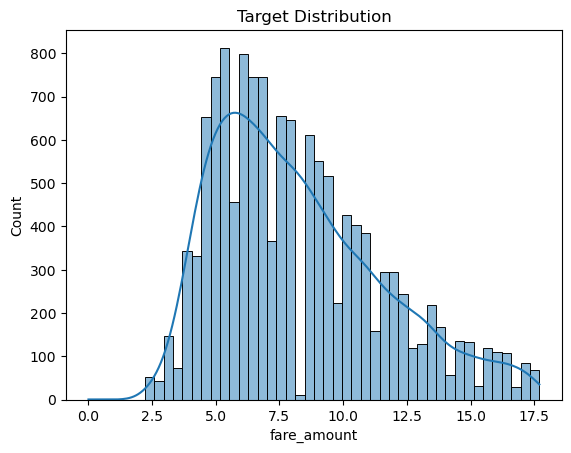

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df['fare_amount'], kde=True)
plt.title("Target Distribution")
plt.show()

In [27]:
features = ['passenger_count', 'hour', 'day', 'month', 'weekday', 'is_weekend','Distance(km)', 'Duration(min)']

In [28]:
X=df[features]
y=df['fare_amount']

In [29]:
X.head()

,passenger_count,hour,day,month,weekday,is_weekend,Distance(km),Duration(min)
0,1.0,17,15,6,0,0,1.029601,2.059201
2,2.0,0,18,8,3,0,1.389132,2.778264
3,1.0,4,21,4,5,1,2.795790,5.591579
4,1.0,7,9,3,1,0,1.998338,3.996676
5,1.0,9,6,1,3,0,3.787980,7.575960


In [30]:
y.head()

0     4.5
2     5.7
3     7.7
4     5.3
5    12.1
Name: fare_amount, dtype: float64

In [31]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [32]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(10588, 8)
(10588,)
(2648, 8)
(2648,)


In [ ]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700],
    'max_depth': [10, 15, 20, 25, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 10],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]  
}


In [34]:
rf = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50, 
    scoring='r2', 
    cv=5, 
    verbose=1,
    random_state=42,
    n_jobs=-1 
)

In [35]:
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 15, 20, 25, 30, 40,
                                                      50, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4, 6, 10],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700]},
                   random_state=42, scoring='r2', verbose=1)

In [36]:
best_rf = rf_random.best_estimator_

In [37]:
y_pred=best_rf.predict(X_test)

In [38]:
def mean_absolute_error(y_true,y_pred):
    return np.mean(np.abs(y_true-y_pred))

def mean_squared_error(y_true,y_pred):
    return np.mean((y_true-y_pred)**2)

def root_mean_squared_error(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def r2_score(y_true, y_pred):
    total_sum_of_squares=np.sum((y_true - np.mean(y_true)) ** 2)
    residual_sum_of_squares= np.sum((y_true-y_pred)**2)
    return 1 - (residual_sum_of_squares / total_sum_of_squares)


In [39]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


In [40]:
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

Mean Absolute Error (MAE): 1.394
Mean Squared Error (MSE): 3.591
Root Mean Squared Error (RMSE): 1.895
R² Score: 0.654


In [41]:
import joblib


In [42]:
joblib.dump(rf_random.best_estimator_,'rf_model.pkl')

['rf_model.pkl']